In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from io import BytesIO
import pickle as pkl

BLOCKSIZE = 8

In [ ]:

def measure_image_loss(original, compressed):
    numel = np.prod(original.size)
    original = np.array(original)
    compressed = np.array(compressed)
    loss = np.sum(np.power(original - compressed, 2))
    return loss / numel

def compress_image(original, quality):
    buffer = BytesIO()
    original.save(buffer, format='JPEG', quality=quality)
    buffer.seek(0)
    compressed = Image.open(buffer)
    return compressed

def measure_quality_curve(original, qualities):
    losses = []
    for quality in qualities:
        compressed = compress_image(original, quality)
        loss = measure_image_loss(original, compressed)
        losses.append(loss)
    return losses

def shift_image(image, shift=(0, 0)):
    """Shift the image by the specified amount. Resizes the image to fit the new size.
    Any pixels that are shifted out of the image are lost. Uses a numpy implementation for speed."""
    image = np.array(image)
    shift = np.array(shift)
    new_image = np.zeros_like(image)
    new_image[max(0, shift[0]):min(image.shape[0], image.shape[0] + shift[0]),
              max(0, shift[1]):min(image.shape[1], image.shape[1] + shift[1])] = image[max(0, -shift[0]):min(image.shape[0], image.shape[0] - shift[0]),
                                                                                      max(0, -shift[1]):min(image.shape[1], image.shape[1] - shift[1])]
    return Image.fromarray(new_image)

In [ ]:
def experiment():
    # We use the new Lena image https://mortenhannemose.github.io/lena/ to demonstrate the JPEG compression algorithm.
    original = Image.open('Lena_2048.png')
    qualities = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]

    blocksweep_x = list(range(0, BLOCKSIZE+1, 1))
    blocksweep_y = blocksweep_x

    total = len(qualities) * len(blocksweep_x) * len(blocksweep_y)

    metadata = {
        'qualities': qualities,
        'blocksweep_x': blocksweep_x,
        'blocksweep_y': blocksweep_y,
        'total': total
    }

    df = pd.DataFrame()

    # Create loss-compression curves for different shifts.
    # We are interested in post-compression shifts, to see what jpeg block artifacts do to the image.
    for i, shiftx in enumerate(blocksweep_x):
        for j, shifty in enumerate(blocksweep_y):
            for k, quality in enumerate(qualities):
                compressed_original = compress_image(original, quality)
                so_far = i * len(qualities) * len(blocksweep_y) + j * len(qualities) + k

                print(f'Quality: {quality}, Shift: ({shiftx}, {shifty})', f"{so_far}/{total}")
                shifted_original = shift_image(compressed_original, (shiftx, shifty))
                losses = measure_quality_curve(shifted_original, qualities)
                df[quality, shiftx, shifty] = losses

    return df, metadata

In [4]:
import pickle as pkl

out, mdat = experiment()
d = {'df': out, 'metadata': mdat}
with open('data.pkl', 'wb') as f:
    pkl.dump(d, f)

NameError: name 'experiment' is not defined

In [6]:
# Plot the results
with open('data.pkl', 'rb') as f:
    d = pkl.load(f)

df = d['df']
mdat = d['metadata']
qualities = mdat['qualities']
blocksweep_x = mdat['blocksweep_x']
blocksweep_y = mdat['blocksweep_y']

In [ ]:
sns.set_style('whitegrid')
# create a grid of plots - one for each quality
fig, ax = plt.subplots(len(qualities), 1, figsize=(10, 20))
for i, quality in enumerate(qualities):
    ax[i].set_title(f'Quality: {quality}')
    for j, shiftx in enumerate(blocksweep_x):
        for k, shifty in enumerate(blocksweep_y):
            xs = qualities
            ys = df[quality, shiftx, shifty]
            ax[i].plot(xs, ys, label=f'Shift: ({shiftx}, {shifty})')
    ax[i].set_xlabel('Quality')
    ax[i].set_ylabel('Loss')
    ax[i].legend()
plt.tight_layout()

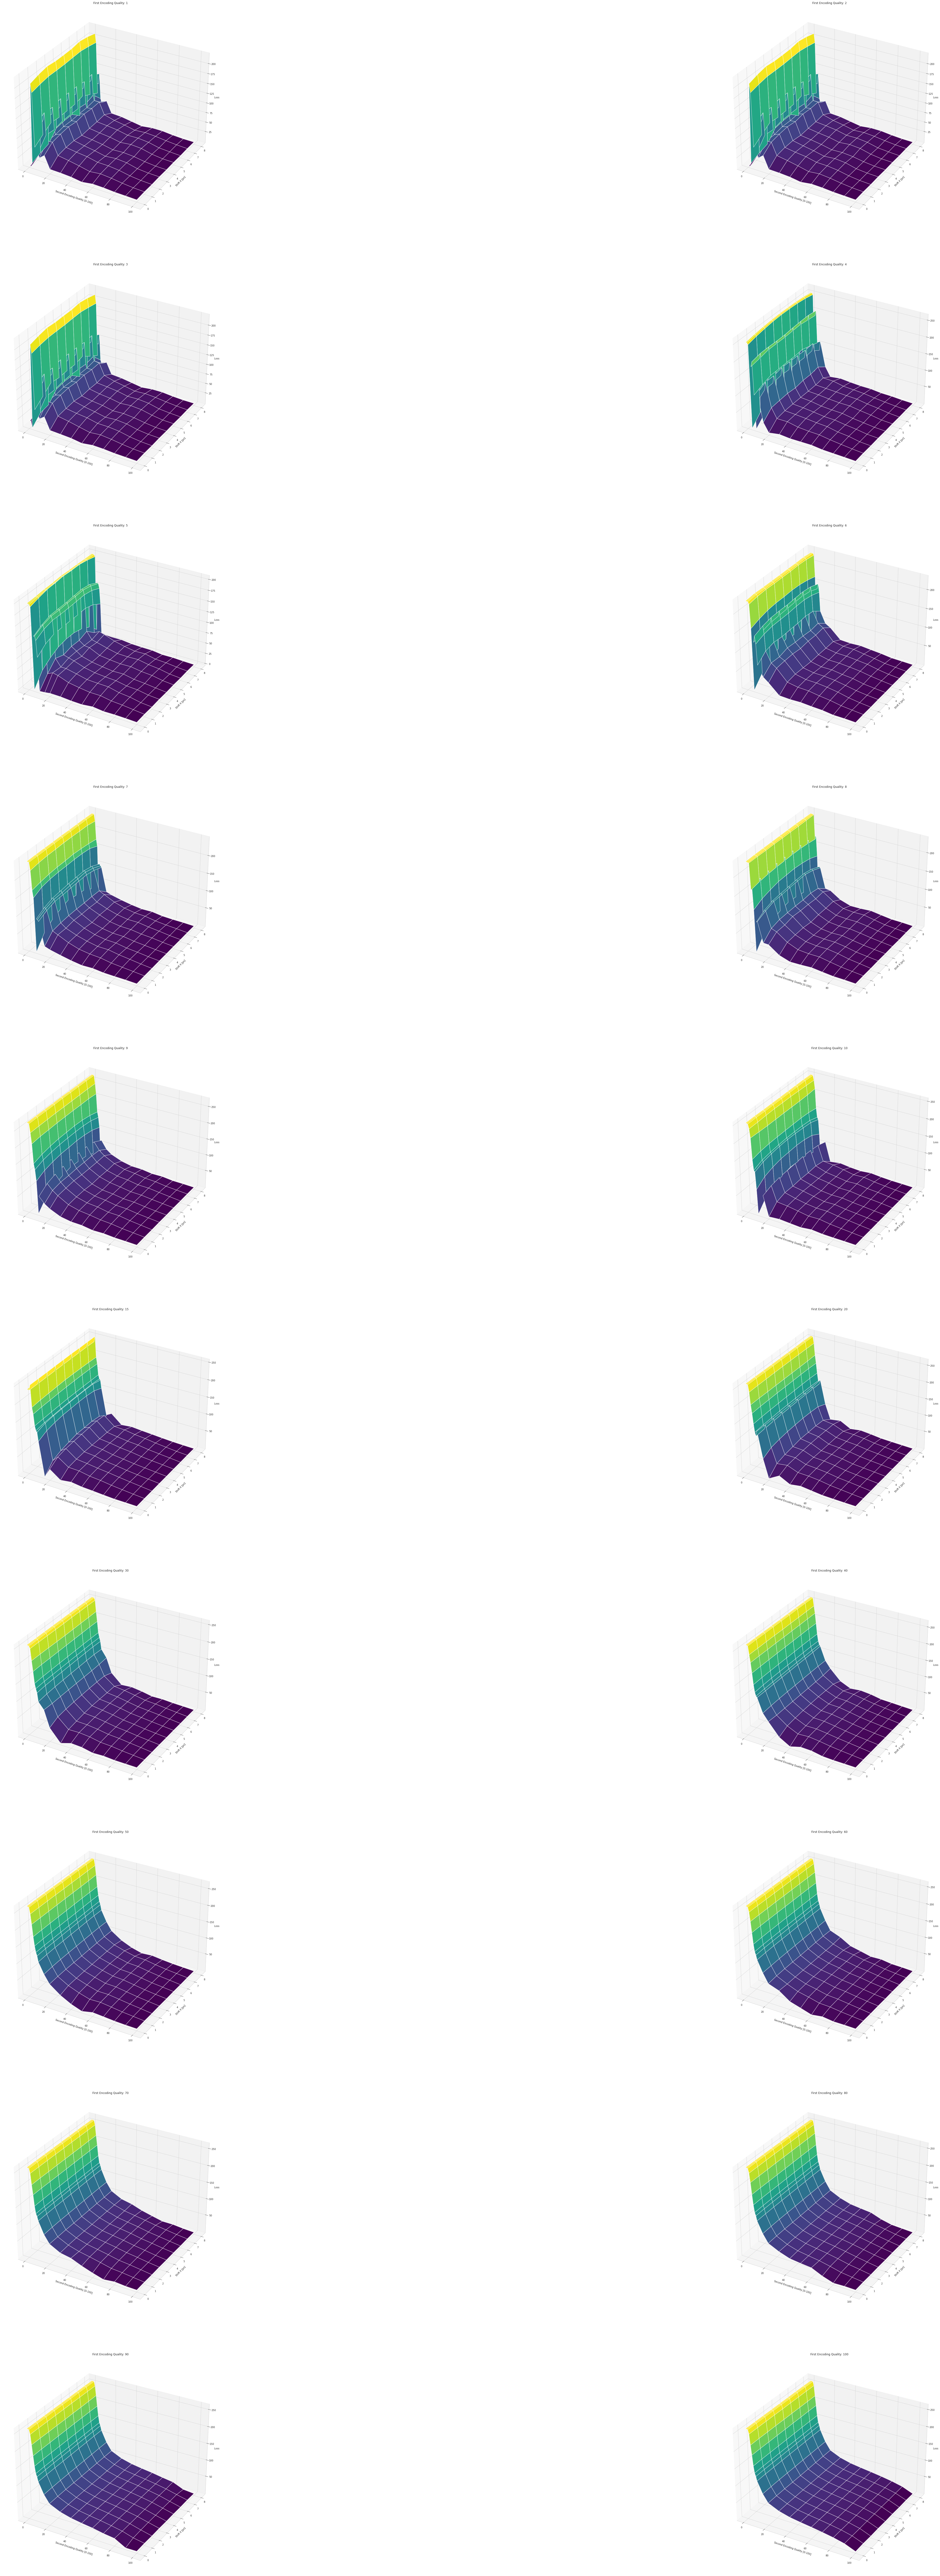

In [20]:
# Plot a surface instead. For now, ignore shift in y direction. (stay at 0)
fig = plt.figure(figsize=(100, 2000))


totalQualities = len(qualities)
# factorise the total number of plots into a grid
factors = [i for i in range(1, totalQualities+1) if totalQualities % i == 0]
# max of 3 columns in the grid
factors = [i for i in factors if i <= 3]
xG = factors[int(len(factors)/2)]
yG = int(totalQualities / xG)

if xG < yG:
    xG, yG = yG, xG

for i, q in enumerate(qualities):
    # create a new subplot for each quality in a grid
    ax = fig.add_subplot(xG, yG, i+1, projection='3d')

    X, Y = np.meshgrid(qualities, blocksweep_x)
    Z = np.array([df[q, shiftx, 0] for shiftx in blocksweep_x])
    ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_xlabel('Second Encoding Quality [0-100]')
    ax.set_ylabel('Shift X [px]')
    ax.set_zlabel('Loss')
    ax.set_title(f'First Encoding Quality: {q}')

plt.show()
